**Praktikum 1**

RNN untuk Analisis Sentimen

---

**Setup**

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [1]:
import numpy as np # Membantu dalam manipulasi data numerik, seperti array, matriks, dan operasi matematika
import tensorflow_datasets as tfds # Menyediakan berbagai dataset yang siap digunakan
import tensorflow as tf # Menyediakan berbagai fungsi dan kelas untuk membangun, melatih, dan menjalankan model machine learning

tfds.disable_progress_bar() # Menonaktifkan progress bar dari TensorFlow Datasets

In [2]:
import matplotlib.pyplot as plt # Berguna dalam memvisualisasikan data

def plot_graphs(history, metric):
    plt.plot(history.history[metric]) # Menampilkan kurva loss atau akurasi model
    plt.plot(history.history['val_'+metric], '') # Menampilkan  kurva loss atau akurasi validasi
    plt.xlabel("Epochs") # Memberi label pada sisi horizontal
    plt.ylabel(metric) # Memberi label pada sisi vertikal
    plt.legend([metric, 'val_'+metric]) # Menambahkan daftar label

**Setup input pipeline**

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan [TFDS](https://www.tensorflow.org/datasets)
. Lihat [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) jika ingin me load data secara manual

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True) # Memuat data supervised dengan dataset berupa imdb_review
train_dataset, test_dataset = dataset['train'], dataset['test'] # Membagi dataset menjadi data uji dan data latih

train_dataset.element_spec # Mendapatkan struktur data dari elemen-elemen dalam dataset

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1): # Perulangan berdasarkan pembagian train_dataset.take(1) menjadi example dan label
    print('text: ', example.numpy()) # Menampilkan data contoh teks
    print('label: ', label.numpy()) # Menampilkan label

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
BUFFER_SIZE = 10000 # Inisialisasi variabel BUFFER_SIZE
BATCH_SIZE = 64 # Inisialisasi variabel BATCH_SIZE

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Mempersiapkan train_dataset dengan melakukan pengacakan dan mengatur batch untuk mencegah overfitting serta prefetch untuk mengurangi waktu memuat data
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Mempersiapkan test_dataset dengan melakukan pengacakan dan mengatur batch untuk mencegah overfitting serta prefetch untuk mengurangi waktu memuat data

for example, label in train_dataset.take(1): # Perulangan berdasarkan pembagian train_dataset.take(1) menjadi example dan label
    print('texts: ', example.numpy()[:3]) # Menampilkan 3 data contoh teks
    print()
    print('labels: ', label.numpy()[:3]) # Menampilkan 3 label

texts:  [b"Whilst I have loved haunted house movies such as Amityville and Poltergeist, this made for TV adaption of Susan Hills book packs a huge punch on the horrors of Hollywood.<br /><br />With a brilliant cast (many of which star in Heartbeat and other TV dramas), great acting, and fantastic setting (which portrays 1920's life convincingly), it has all the right ingredients to entice the viewer into what is a powerful ghost story.<br /><br />Herbert Wise did not need blood, violence, or gore to send chills down the spines of an audience. Using your own imagination, the Woman In Black is a figure of fear and dread, and whose presence is never absent once she first appears.<br /><br />The main character Arthur Kidd, a solicitor, learns about his unseen spectre on his mission to settle the estate. The widow dies and Arthur spends few nights inside her dreary home in which he notices many oddities, which may haunt him for some days. Some of the scenes are very unsettling and claustrop

**Buat Teks Encoder**

***

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [6]:
VOCAB_SIZE = 1000 # Inisialisasi variabel VOCAB_SIZE
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE) # Mengubah text menjadi nilai numerik dengan maksimal token sebanyak VOCAB_SIZE
encoder.adapt(train_dataset.map(lambda text, label: text)) # Menyesuaikan encoder dengan train_dataset

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
vocab = np.array(encoder.get_vocabulary()) # Memperoleh vocabulary yang telah dipelajari encoder dari train_dataset
vocab[:20] # Menampilkan 20 data variabel vocab

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [8]:
encoded_example = encoder(example)[:3].numpy() # Merubah data teks menjadi numerik dengan encoder dan mengambil 3 data
encoded_example # Menampilkan array encoded_example

array([[  1,  10,  26, ...,   0,   0,   0],
       [450,   4,   1, ...,   0,   0,   0],
       [  1, 742,   1, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation" (mengubah semua teks menjadi huruf kecil dan menghapus semua tanda baca sebelum dienkode).
- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [9]:
for n in range(3): # Melakukan 3 kali perulangan
    print("Original: ", example[n].numpy()) # Menampilkan nilai example pada indeks n
    print("Round-trip: ", " ".join(vocab[encoded_example[n]])) # Menampilkan data list encode_example pada indeks n yang sudah digabungkan
    print()

# UNK => Unknown

Original:  b"Whilst I have loved haunted house movies such as Amityville and Poltergeist, this made for TV adaption of Susan Hills book packs a huge punch on the horrors of Hollywood.<br /><br />With a brilliant cast (many of which star in Heartbeat and other TV dramas), great acting, and fantastic setting (which portrays 1920's life convincingly), it has all the right ingredients to entice the viewer into what is a powerful ghost story.<br /><br />Herbert Wise did not need blood, violence, or gore to send chills down the spines of an audience. Using your own imagination, the Woman In Black is a figure of fear and dread, and whose presence is never absent once she first appears.<br /><br />The main character Arthur Kidd, a solicitor, learns about his unseen spectre on his mission to settle the estate. The widow dies and Arthur spends few nights inside her dreary home in which he notices many oddities, which may haunt him for some days. Some of the scenes are very unsettling and claustr

**Buat Model**

---

![image](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

---

diagram model dapat dilihat pada gambar diatas

1. Model ini dapat dibuat sebagai tf.keras.Sequential.

2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.

3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.

4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.

- Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.

- Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.


5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.
Kode nya adalah sebagai berikut :

In [10]:
model = tf.keras.Sequential([ # Membual model Sequential
    encoder, # Variabel encoder sebelumnya sebagai parameter
    tf.keras.layers.Embedding( # Membuat embeded layer
        input_dim=len(encoder.get_vocabulary()), # Jumlah token dalam vocabulary
        output_dim=64, # Banyak fitur yang mewakili token
        mask_zero=True), # Mengabaikan token dengan indeks 0
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # Membuat layer bidirectional dengan layer LTSM 64 unit
    tf.keras.layers.Dense(64, activation='relu'), # Menambhakan layer Dense (Fully-Connected) dengan 64 neuron dan fungsi aktivasi berupa ReLU
    tf.keras.layers.Dense(1) # Menambhakan layer Dense (Fully-Connected) dengan 1 neuron
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada Keras RNN guide

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [11]:
print([layer.supports_masking for layer in model.layers]) # Menampilkan daftar boolean apakah model mendukung masking

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.') # Inisialisasi variabel sample_text
predictions = model.predict(np.array([sample_text])) # Melakukan prediksi nilai berdasarkan sample_text yang dirubah ke array numpy
print(predictions[0]) # Menampilkan nilai prediksi pertama

1/1 [==============================] - 3s 3s/step
[0.00751726]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [13]:
# predict on a sample text with padding

padding = "the " * 2000 # Membuat variabel padding
predictions = model.predict(np.array([sample_text, padding])) # Melakukan prediksi nilai berdasarkan sample_text dan padding yang dirubah ke array numpy
print(predictions[0]) # Menampilkan nilai prediksi pertama

1/1 [==============================] - 1s 549ms/step
[0.00751726]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # Compile Model dengan argument loss berdasarkan BinaryCrossentropy dengan output logits (nilai numerik yang mewakili kemungkinan kelas 1 dan 0)
              optimizer=tf.keras.optimizers.Adam(1e-4), # Menggunakan optimizer ADAM dengan learning rate 1e-4
              metrics=['accuracy']) # Dan argument metrics dengan accuracy

**Train Model**

In [15]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30) # Melatih model dengan train_dataset dan 10 epoch serta 30 sampel validasi

Epoch 1/10
391/391 [==============================] - 568s 1s/step - loss: 0.6418 - accuracy: 0.5844 - val_loss: 0.5051 - val_accuracy: 0.7698
Epoch 2/10
391/391 [==============================] - 546s 1s/step - loss: 0.4048 - accuracy: 0.8162 - val_loss: 0.3725 - val_accuracy: 0.8443
Epoch 3/10
391/391 [==============================] - 549s 1s/step - loss: 0.3412 - accuracy: 0.8495 - val_loss: 0.3385 - val_accuracy: 0.8500
Epoch 4/10
391/391 [==============================] - 555s 1s/step - loss: 0.3227 - accuracy: 0.8601 - val_loss: 0.3285 - val_accuracy: 0.8552
Epoch 5/10
391/391 [==============================] - 547s 1s/step - loss: 0.3131 - accuracy: 0.8624 - val_loss: 0.3361 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 545s 1s/step - loss: 0.3050 - accuracy: 0.8673 - val_loss: 0.3272 - val_accuracy: 0.8432
Epoch 7/10
391/391 [==============================] - 547s 1s/step - loss: 0.3039 - accuracy: 0.8691 - val_loss: 0.3278 - val_accuracy: 0.8589

In [16]:
test_loss, test_acc = model.evaluate(test_dataset) # Menyimpan nilai loss dan accuracy hasil dari evaluasi model dengan test_dataset

print('Test Loss:', test_loss) # Menampilkan nilai variabel test_loss
print('Test Accuracy:', test_acc) # Menampilkan nilai variabel test_acc

391/391 [==============================] - 134s 342ms/step - loss: 0.3246 - accuracy: 0.8606
Test Loss: 0.32460516691207886
Test Accuracy: 0.8605999946594238


(0.0, 0.6589579313993454)

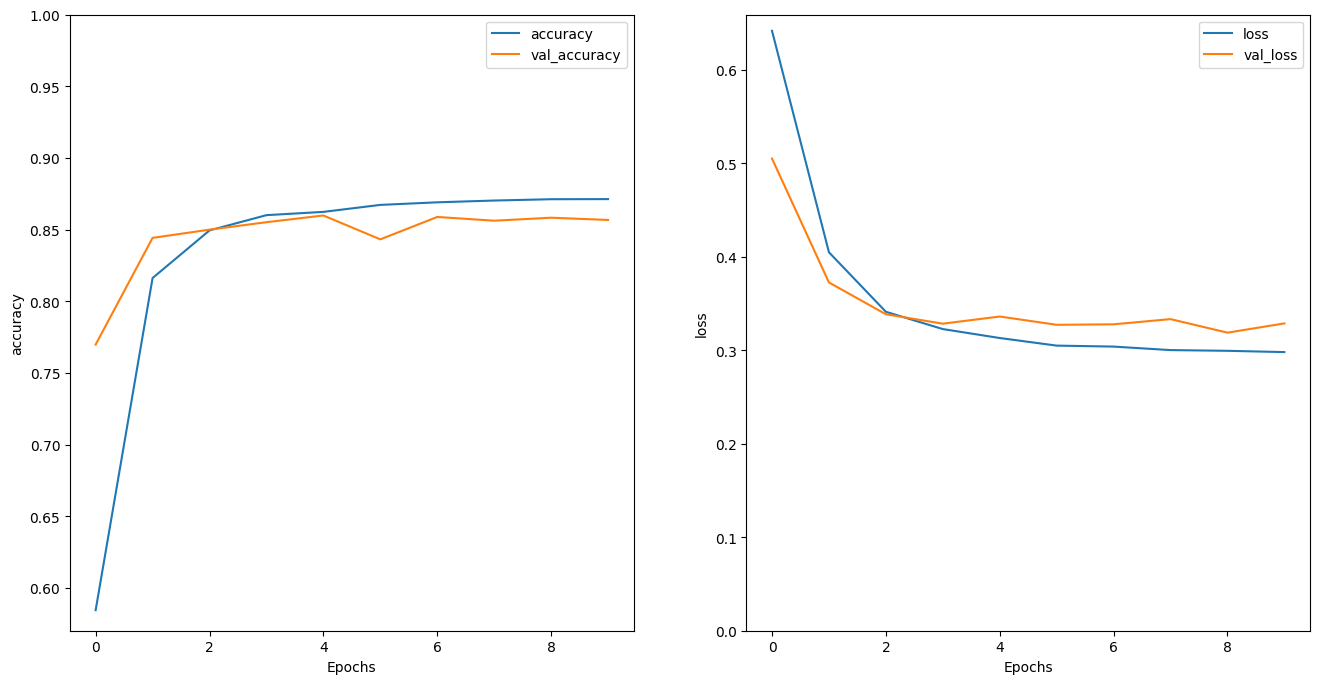

In [17]:
plt.figure(figsize=(16, 8)) # Membuat figure dengan ukuran 16 x 8
plt.subplot(1, 2, 1) # membuat subplot dengan 1 baris dan 2 kolom, dan subplot ini akan ditempatkan di indeks 1
plot_graphs(history, 'accuracy') # memplot grafik akurasi dari objek History
plt.ylim(None, 1) # mengatur batas y dari grafik akurasi agar dimulai dari 0 dan berakhir di 1
plt.subplot(1, 2, 2) # membuat subplot dengan 1 baris dan 2 kolom, dan subplot ini akan ditempatkan di indeks 2
plot_graphs(history, 'loss') # memplot grafik loss dari objek History
plt.ylim(0, None) #  mengatur batas y dari grafik loss agar dimulai dari 0

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.') # Inisialisasi variabel sample_text

predictions = model.predict(np.array([sample_text])) # Melakukan prediksi nilai berdasarkan sample_text yang dirubah ke array numpy

1/1 [==============================] - 3s 3s/step


Stack two or more LSTM layers
Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :

- Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.
- Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [19]:
model = tf.keras.Sequential([ # Membual model Sequential
    encoder, # Variabel encoder sebelumnya sebagai parameter
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True), # Membuat embeded layer dengan jumlah token dalam vocabulary dan 64 banyak fitur yang mewakili token serta Mengabaikan token dengan indeks 0
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # Membuat layer bidirectional dengan layer LTSM 64 unit dan mengembalikan seluruh urutan output
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # # Membuat layer bidirectional dengan layer LTSM 32 unit
    tf.keras.layers.Dense(64, activation='relu'), # Menambhakan layer Dense (Fully-Connected) dengan 64 neuron dan fungsi aktivasi berupa ReLU
    tf.keras.layers.Dropout(0.5), # enonaktifkan 50% dari unit di lapisan sebelumnya secara acak pada setiap iterasi pelatihan
    tf.keras.layers.Dense(1) # Menambhakan layer Dense (Fully-Connected) dengan 1 neuron
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # Compile Model dengan argument loss berdasarkan BinaryCrossentropy dengan output logits (nilai numerik yang mewakili kemungkinan kelas 1 dan 0)
            optimizer=tf.keras.optimizers.Adam(1e-4), # Menggunakan optimizer ADAM dengan learning rate 1e-4
            metrics=['accuracy']) # Dan argument metrics dengan accuracy

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30) # Melatih model dengan train_dataset dan 10 epoch serta 30 sampel validasi

Epoch 1/10
391/391 [==============================] - 1098s 3s/step - loss: 0.6285 - accuracy: 0.5842 - val_loss: 0.4182 - val_accuracy: 0.8141
Epoch 2/10
391/391 [==============================] - 1090s 3s/step - loss: 0.3837 - accuracy: 0.8290 - val_loss: 0.3504 - val_accuracy: 0.8557
Epoch 3/10
318/391 [=======================>......] - ETA: 3:18 - loss: 0.3437 - accuracy: 0.8527

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset) # Menyimpan nilai loss dan accuracy hasil dari evaluasi model dengan test_dataset

print('Test Loss:', test_loss) # Menampilkan nilai variabel test_loss
print('Test Accuracy:', test_acc) # Menampilkan nilai variabel test_acc

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.') # Inisialisasi variabel sample_text

predictions = model.predict(np.array([sample_text])) # Melakukan prediksi nilai berdasarkan sample_text yang dirubah ke array numpy
print(predictions) # Menampilkan nilai prediksi

In [ ]:
plt.figure(figsize=(16, 6)) # Membuat figure dengan ukuran 16 x 6
plt.subplot(1, 2, 1) # membuat subplot dengan 1 baris dan 2 kolom, dan subplot ini akan ditempatkan di indeks 1
plot_graphs(history, 'accuracy') # memplot grafik akurasi dari objek History
plt.subplot(1, 2, 2) # membuat subplot dengan 1 baris dan 2 kolom, dan subplot ini akan ditempatkan di indeks 2
plot_graphs(history, 'loss') # memplot grafik loss dari objek History

**Catatan**

- Informasi menarik lain terkait dengan [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).
- Informasi membuat custom RNN --> [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).